Epoch: 1000 cost = 0.605884
Epoch: 2000 cost = 0.544089
Epoch: 3000 cost = 0.511806
Epoch: 4000 cost = 0.497618
Epoch: 5000 cost = 0.492909
Epoch: 6000 cost = 0.491957
Epoch: 7000 cost = 0.491844
Epoch: 8000 cost = 0.491793
'book is sports' is objective
'i hate soccer' is subjective


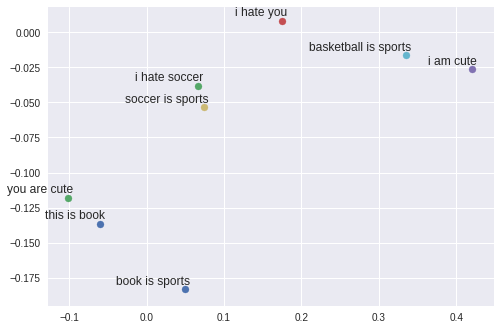

In [0]:
'''
  code by Minho Ryu @bzantium
  
'''
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

num_classes = 2 # 0 or 1

# 3 words sentences (=sequence_length is 3)
train_sents = ["this is book","you are cute", "i hate you", "i am cute","soccer is sports", "basketball is sports"]
test_sents = ["book is sports", "i hate soccer"] # [subjective, objective]
labels = [1,0,0,0,1,0] # 1 is objective, 0 is subjective.

tokens = []
for sent in train_sents:
  tokens.append(sent.split())

test_tokens = []
for sent in test_sents:
  test_tokens.append(sent.split())
  
word_list = " ".join(train_sents).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

inputs = []
for sen in train_sents:
    inputs.append(np.asarray([word_dict[n] for n in sen.split()]))

outputs = []
for out in labels:
    outputs.append(np.eye(num_classes)[out]) # ONE-HOT : To using Tensor Softmax Loss function

tagged = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(tokens)]

num_epochs_per_cycle = 5
num_cycles = 20
vec_size = 2
num_classes = 2
alpha = 1e-1
min_alpha = 1e-3
doc2vec = Doc2Vec(vector_size=vec_size, alpha=alpha, min_count=2, dm=0)
doc2vec.build_vocab(tagged)
for cycle in range(num_cycles):
    doc2vec.train(tagged, total_examples=doc2vec.corpus_count,
                epochs=num_epochs_per_cycle, start_alpha=alpha, end_alpha=min_alpha)

inputs = []
for i in range(len(train_sents)):
    inputs.append(doc2vec.docvecs[str(i)])

tests = []
for i in range(len(test_sents)):
    tests.append(doc2vec.infer_vector(test_tokens[i], alpha=alpha, min_alpha=min_alpha, steps=5))
    
class FullyConnected(object):
    def __init__(self, sess, vec_size, num_classes):
        self.sess = sess
        self.vec_size = vec_size
        self.num_classes = num_classes
        self._build_model()
        
    def _build_model(self):
        with tf.variable_scope("placeholder", reuse=tf.AUTO_REUSE):
            self.X = tf.placeholder(tf.float32, shape=[None, self.vec_size])
            self.Y = tf.placeholder(tf.int32, shape=[None, self.num_classes])
        
        with tf.variable_scope("output", reuse=tf.AUTO_REUSE):
            W = tf.Variable(tf.random.truncated_normal([self.vec_size, self.num_classes], 0.0, 1.0))
            b = tf.Variable(tf.constant(0.1, shape=[self.num_classes]))
        
        logits = tf.nn.xw_plus_b(self.X, W, b) 
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)
        hypothesis = tf.nn.softmax(logits)
        self.predictions = tf.argmax(hypothesis, 1)

        sess.run(tf.global_variables_initializer())
    
    def train(self, inputs, labels):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: inputs, self.Y: labels})
     
    def predict(self, inputs):
        return self.sess.run([self.predictions], feed_dict={self.X: inputs})

run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True
sess = tf.Session(config=run_config)
model = FullyConnected(sess, vec_size, num_classes)

for epoch in range(8000):
    loss, _ = model.train(inputs, outputs)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

# Test
result = model.predict(tests)[0]
for i, text in enumerate(test_sents):
  if result[i] == 0:
      print("\'" + text + "\'", "is subjective")
  else:
      print("\'"+ text + "\'", "is objective")

sentences = []
sentences.extend(train_sents)
sentences.extend(test_sents)

embeded = []
embeded.extend(inputs)
embeded.extend(tests)

for i, label in enumerate(sentences):
    x, y = embeded[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()